In [14]:
import scipy
import numpy
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Sequential, layers, callbacks
from tensorflow.keras.layers import Dense, LSTM, Dropout, GRU
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt
import matplotlib.dates as mdates
from matplotlib.dates import MonthLocator, DateFormatter
from IPython.core.pylabtools import figsize
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
import seaborn as sns

# Import Data

In [15]:
# Load data from Excel file
file_path = '/content/Data Daily 2023-2025.xlsx'
df = pd.read_excel(file_path)

# Explore the first five rows
print(df.head())
print(df.tail())

# Data description
print(df.describe())
print(df.dtypes)

  Daily_Period  TMA_Daily
0   2023-01-01  43.750000
1   2023-01-02  36.666667
2   2023-01-03  32.916667
3   2023-01-04  32.173913
4   2023-01-05  30.000000
    Daily_Period  TMA_Daily
846   2025-04-26  20.000000
847   2025-04-27  20.000000
848   2025-04-28  21.666667
849   2025-04-29  20.000000
850   2025-04-30  14.166667
              Daily_Period   TMA_Daily
count                  851  851.000000
mean   2024-03-01 00:00:00   18.148203
min    2023-01-01 00:00:00   10.000000
25%    2023-08-01 12:00:00   10.000000
50%    2024-03-01 00:00:00   13.750000
75%    2024-09-29 12:00:00   22.708333
max    2025-04-30 00:00:00   80.833333
std                    NaN   10.305936
Daily_Period    datetime64[ns]
TMA_Daily              float64
dtype: object


# Eksplorasi Data

<ipython-input-16-1afa4e80327b>:9: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


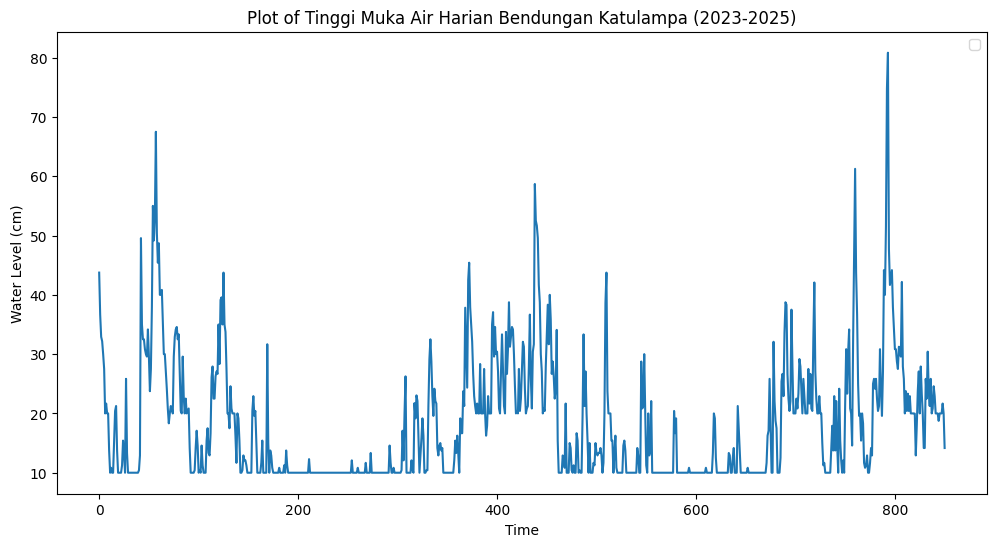

In [16]:
# Plot the three variables in one graph
plt.figure(figsize=(12, 6))
plt.plot(df['TMA_Daily'])

# Add labels and legend
plt.xlabel('Time')
plt.ylabel('Water Level (cm)')
plt.title('Plot of Tinggi Muka Air Harian Bendungan Katulampa (2023-2025)')
plt.legend()

# Show the plot
plt.show()

# Splitting Data

In [17]:
# Split the dataset into train and test data
train_size = 731
train_dataset, test_dataset = df.iloc[:train_size], df.iloc[train_size:]

# Split train data to X and y
X_train_numeric = train_dataset.drop(['Daily_Period'], axis=1)
y_train = train_dataset.loc[:, ['TMA_Daily']]

# Split test data to X and y
X_test_numeric = test_dataset.drop(['Daily_Period'], axis=1)
y_test = test_dataset.loc[:, ['TMA_Daily']]

# Transformasi Data

In [18]:
# Data transformation

# Different scaler for input and output
scaler_x = MinMaxScaler(feature_range=(0, 1))
scaler_y = MinMaxScaler(feature_range=(0, 1))
# Fit the scaler using available training data
input_scaler = scaler_x.fit(X_train_numeric)  # X_train_numeric should contain only numeric features
output_scaler = scaler_y.fit(y_train)
# Apply the scaler to training data
train_y_norm = output_scaler.transform(y_train)
train_x_norm = input_scaler.transform(X_train_numeric)
# Apply the scaler to test data
test_y_norm = output_scaler.transform(y_test)
test_x_norm = input_scaler.transform(X_test_numeric)  # X_test_numeric should contain only numeric features

# Normalisasi Data

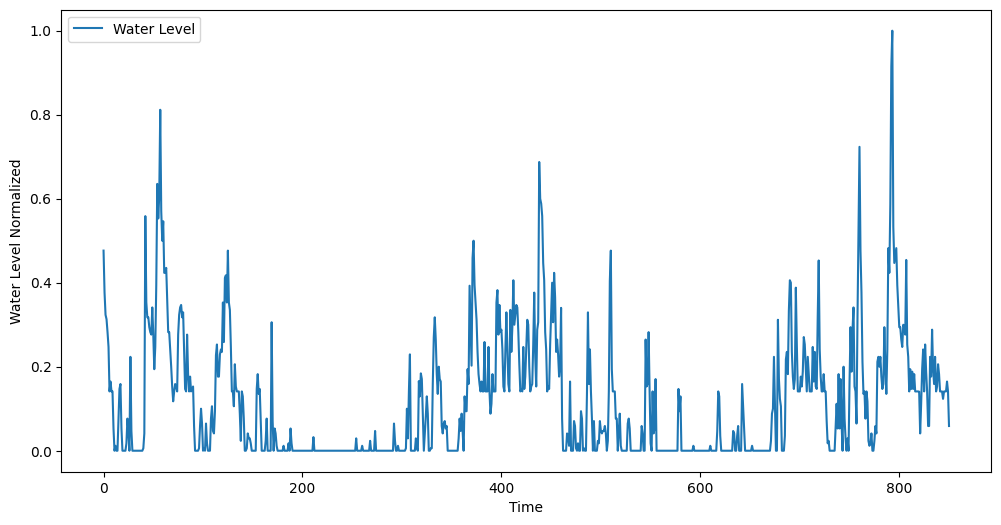

In [19]:
# Normalize the data
scaler = MinMaxScaler()
dfforgr = df.drop(['Daily_Period'], axis=1)
df_normalized = pd.DataFrame(scaler.fit_transform(dfforgr), columns=dfforgr.columns)
# Plot the normalized data
plt.figure(figsize=(12, 6))
plt.plot(df_normalized['TMA_Daily'], label='Water Level')
# Add labels and legend
plt.xlabel('Time')
plt.ylabel('Water Level Normalized')
plt.legend()
# Show the plot
plt.show()

In [20]:
# Create a 3D Input Dataset
def create_dataset (X, y, time_steps = 1):
    Xs, ys = [], []
    for i in range(len(X)-time_steps):
        v = X[i:i+time_steps, :]
        Xs.append(v)
        ys.append(y[i+time_steps])
    return np.array(Xs), np.array(ys)

TIME_STEPS = 30
X_test, y_test = create_dataset(test_x_norm, test_y_norm, TIME_STEPS)
X_train, y_train = create_dataset(train_x_norm, train_y_norm, TIME_STEPS)
print('X_train.shape: ', X_train.shape)
print('y_train.shape: ', y_train.shape)
print('X_test.shape: ', X_test.shape)
print('y_test.shape: ', y_test.shape)

X_train.shape:  (701, 30, 1)
y_train.shape:  (701, 1)
X_test.shape:  (90, 30, 1)
y_test.shape:  (90, 1)


# Pemodelan LSTM & GRU

In [21]:
# Create LSTM or GRU model
def create_model(units, m):
    model = Sequential()
    # First layer of LSTM
    model.add(m (units = units, return_sequences = True,
                 input_shape = [X_train.shape[1], X_train.shape[2]]))
    model.add(Dropout(0.2))
    # Second layer of LSTM
    model.add(m (units = units))
    model.add(Dropout(0.2))
    model.add(Dense(units = 1))
    #Compile model
    model.compile(loss='mse', optimizer='adam')
    return model

# GRU and LSTM
model_gru = create_model(64, GRU)
model_lstm = create_model(64, LSTM)

# Fit the models
# LSTM and GRU
def fit_model(model):
    early_stop = keras.callbacks.EarlyStopping(monitor = 'val_loss',
                                               patience = 15)
    # shuffle = False because the order of the data matters
    history = model.fit(X_train, y_train, epochs = 100, validation_split = 0.2,
                    batch_size = 32, shuffle = False, callbacks = [early_stop])
    return history
history_lstm = fit_model(model_lstm)
history_gru = fit_model(model_gru)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 12s 245ms/step - loss: 0.0587 - val_loss: 0.0093
Epoch 2/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 96ms/step - loss: 0.0243 - val_loss: 0.0088
Epoch 3/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 82ms/step - loss: 0.0226 - val_loss: 0.0086
Epoch 4/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step - loss: 0.0203 - val_loss: 0.0085
Epoch 5/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - loss: 0.0196 - val_loss: 0.0084
Epoch 6/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - loss: 0.0194 - val_loss: 0.0083
Epoch 7/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - loss: 0.0171 - val_loss: 0.0082
Epoch 8/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - loss: 0.0171 - val_loss: 0.0081
Epoch 9/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - loss: 0.0167 - val_loss: 0.0080
Epoch 10/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - loss: 0.0166 - val_loss: 0.0079
Epoch 11/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step - loss: 0.0151 - val_loss: 0.0079
Epoch 12/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 54ms/st

# Training Loss & Validation Loss

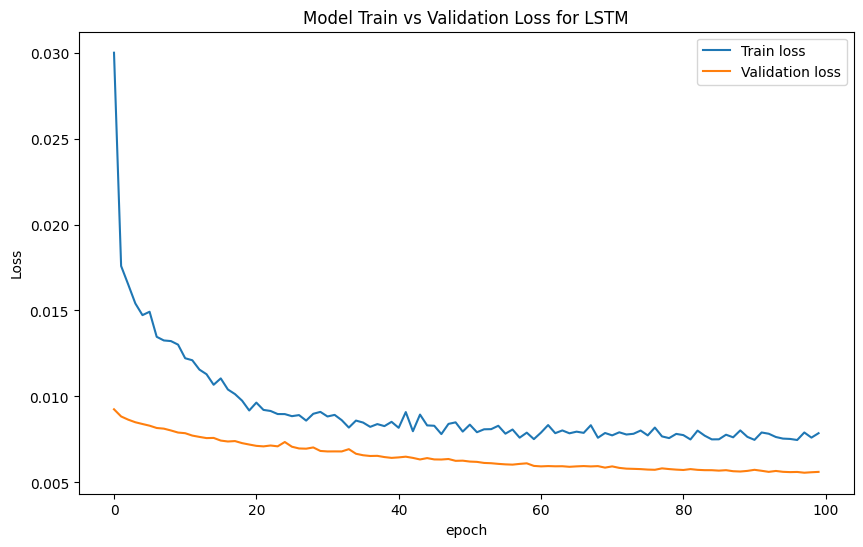

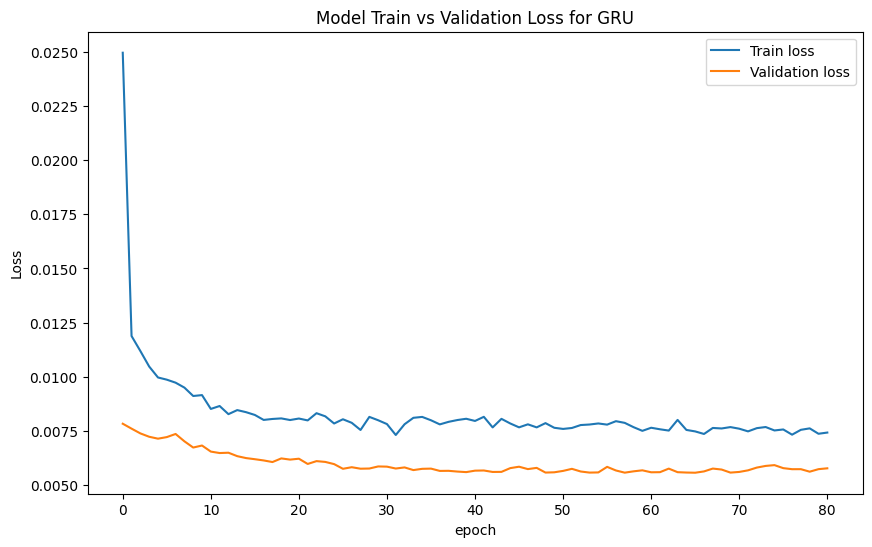

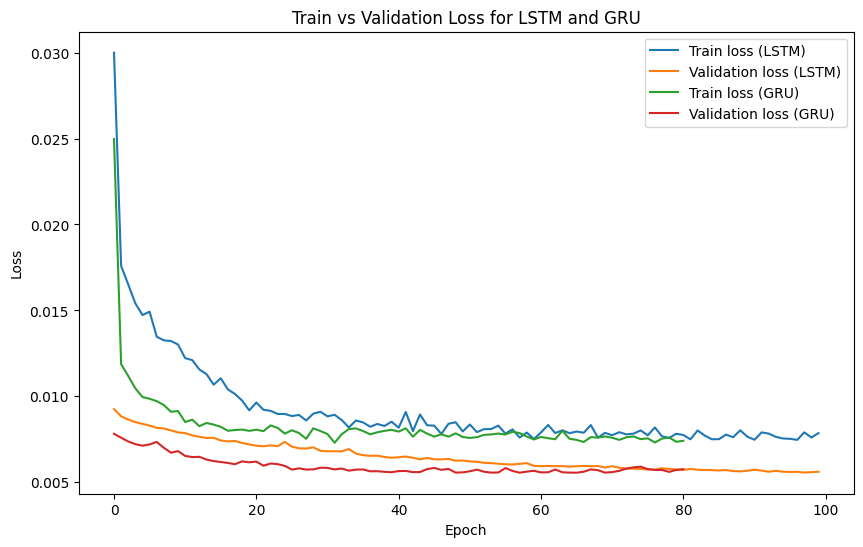

In [22]:
# Plot train loss vs validation loss
def plot_loss (history, model_name):
    plt.figure(figsize = (10, 6))
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model Train vs Validation Loss for ' + model_name)
    plt.ylabel('Loss')
    plt.xlabel('epoch')
    plt.legend(['Train loss', 'Validation loss'], loc='upper right')
plot_loss (history_lstm, 'LSTM')
plot_loss (history_gru, 'GRU')

def plot_loss(history, model_name):
    plt.plot(history.history['loss'], label=f'Train loss ({model_name})')
    plt.plot(history.history['val_loss'], label=f'Validation loss ({model_name})')

# Membuat gambar baru untuk plot
plt.figure(figsize=(10, 6))

# Plot loss untuk tiga model
plot_loss(history_lstm, 'LSTM')
plot_loss(history_gru, 'GRU')

# Menambahkan judul, label, dan legenda
plt.title('Train vs Validation Loss for LSTM and GRU')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Menampilkan grafik
plt.show()

# Inverse Transform

In [23]:
# Inverse target variable for train and test data
# Note that I have to use scaler_y
y_test = scaler_y.inverse_transform(y_test)
y_train = scaler_y.inverse_transform(y_train)

# Prediction LSTM and GRU

1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 295ms/step

3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 167ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 186ms/step


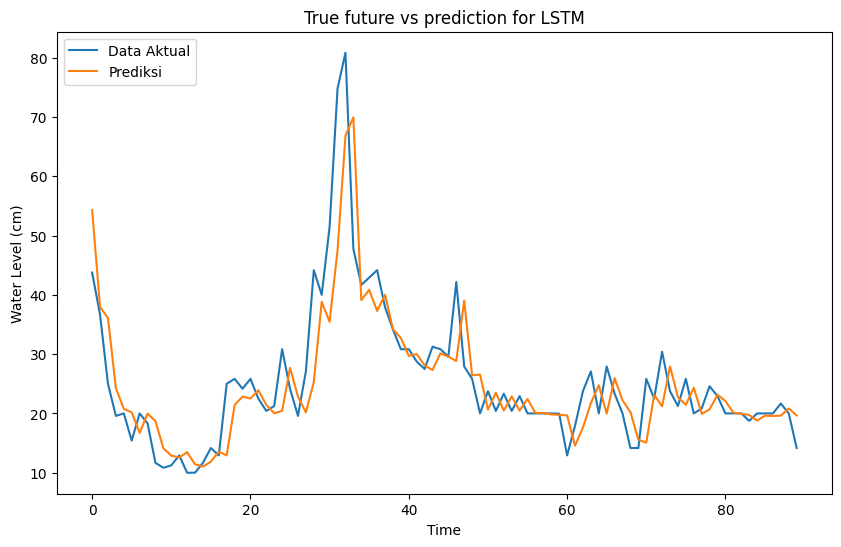

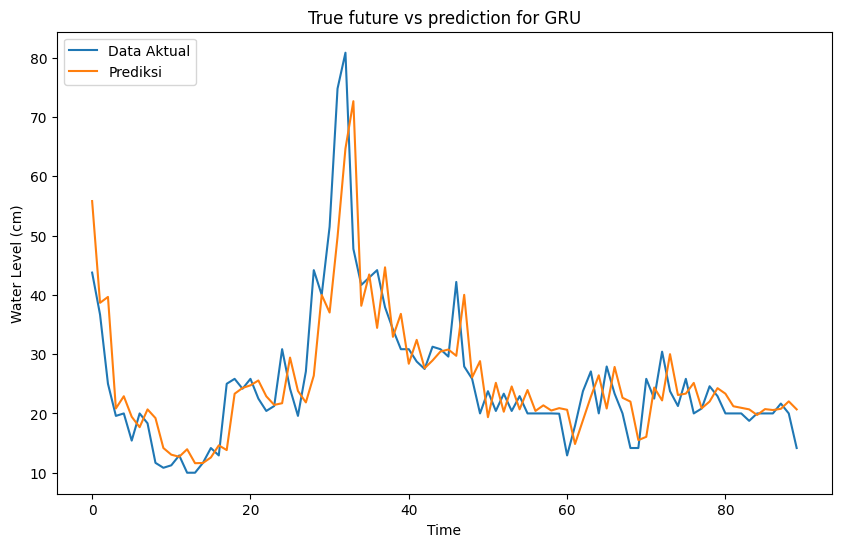

In [24]:
# Make prediction using LSTM and GRU
def prediction(model):
    prediction = model.predict(X_test)
    prediction = scaler_y.inverse_transform(prediction)
    return prediction
prediction_lstm = prediction(model_lstm)
prediction_gru = prediction(model_gru)

# Plot true future vs prediction
def plot_future(prediction, model_name, y_test):
    plt.figure(figsize=(10, 6))

    range_future = len(prediction)

    plt.plot(np.arange(range_future), np.array(y_test), label='Data Aktual')
    plt.plot(np.arange(range_future), np.array(prediction),label='Prediksi')

    plt.title('True future vs prediction for ' + model_name)
    plt.legend(loc='upper left')
    plt.xlabel('Time')
    plt.ylabel('Water Level (cm)')

plot_future(prediction_lstm, 'LSTM', y_test)
plot_future(prediction_gru, 'GRU', y_test)

# Evaluasi Model

In [25]:
# Calculate RMSE, MAE, dan MAPE

# Define a function to calculate MAE and RMSE
def evaluate_prediction(predictions, actual, model_name):
    errors = predictions - actual
    mse = np.square(errors).mean()
    rmse = np.sqrt(mse)
    mae = np.abs(errors).mean()
    mape = np.mean(np.abs(errors / actual)) * 100  # Calculate MAPE

    print(model_name + ':')
    print('Mean Absolute Error: {:.2f}'.format(mae))
    print('Root Mean Square Error: {:.2f}'.format(rmse))
    print('Mean Absolute Percentage Error: {:.2f}%'.format(mape))
    print('')

# Usage
evaluate_prediction(prediction_lstm, y_test, 'LSTM')
evaluate_prediction(prediction_gru, y_test, 'GRU')

LSTM:
Mean Absolute Error: 4.21
Root Mean Square Error: 6.53
Mean Absolute Percentage Error: 15.97%

GRU:
Mean Absolute Error: 4.57
Root Mean Square Error: 6.77
Mean Absolute Percentage Error: 17.63%



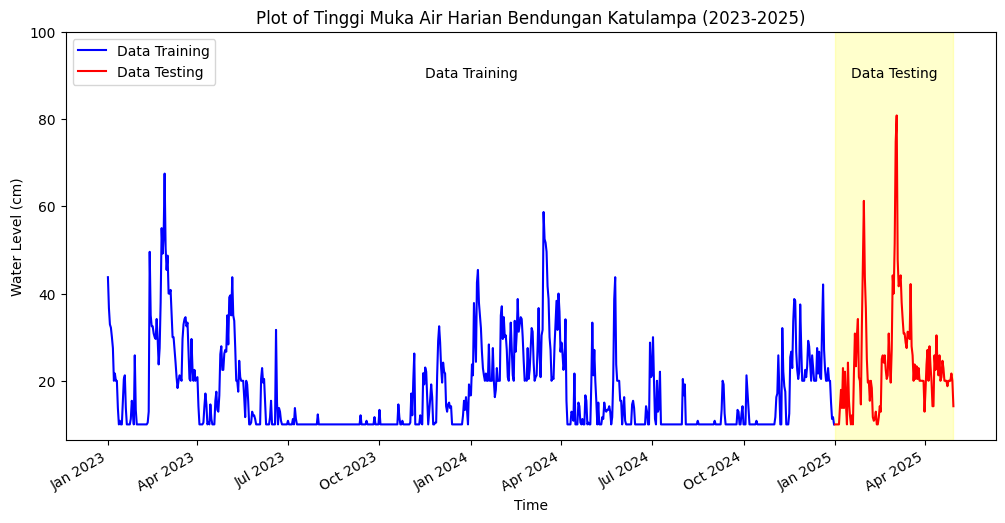

Dimension of train data:  (731, 1)
Dimension of test data:  (120, 1)


In [26]:
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter
import pandas as pd

# Load data from Excel file again
file_path = '/content/Data Daily 2023-2025.xlsx'
df = pd.read_excel(file_path)

# Set the correct date format
df['Daily_Period'] = pd.to_datetime(df['Daily_Period'], format='%Y-%m-%d')
df.set_index('Daily_Period', inplace=True)

# Split the dataset into train and test data
train_size = 731
train_dataset, test_dataset = df.iloc[:train_size], df.iloc[train_size:]

# Plot the three variables in one graph with colored test data
plt.figure(figsize=(12, 6))
plt.plot(train_dataset.index, train_dataset['TMA_Daily'], label='Data Training', color='blue')
plt.plot(test_dataset.index, test_dataset['TMA_Daily'], label='Data Testing', color='red')

# Highlight the area corresponding to the test data with a red background
plt.axvspan(test_dataset.index[0], test_dataset.index[-1], color='yellow', alpha=0.2)

# Add labels and legend
plt.xlabel('Time')
plt.ylabel('Water Level (cm)')
plt.ylim(top=100)
plt.title('Plot of Tinggi Muka Air Harian Bendungan Katulampa (2023-2025)')

# Configure the date format on the x-axis
plt.gca().xaxis.set_major_formatter(DateFormatter('%b %Y'))

# Add text labels for train and test data, placing "Data Testing" above and centered over the test data area
plt.text(train_dataset.index[len(train_dataset)//2], df['TMA_Daily'].max() * 1.1, 'Data Training', verticalalignment='bottom', horizontalalignment='center', color='black')
plt.text(test_dataset.index[len(test_dataset)//2], df['TMA_Daily'].max() * 1.1, 'Data Testing', verticalalignment='bottom', horizontalalignment='center', color='black')

# Show the plot
plt.gcf().autofmt_xdate()  # To improve the layout of overlapping dates
plt.legend() # Add legend back to show labels
plt.show()

print('Dimension of train data: ', train_dataset.shape)
print('Dimension of test data: ', test_dataset.shape)